In [28]:
# =============================================================================
# COMPREHENSIVE FOOD PRICE FORECASTING ANALYSIS
# Comparing Auto ARIMA, Prophet, and Neural Prophet Methods
# =============================================================================

# --- 1. SETUP AND DATA PREPARATION ---
if (!require("forecast")) install.packages("forecast")
if (!require("prophet")) install.packages("prophet")
if (!require("reticulate")) install.packages("reticulate")
if (!require("dplyr")) install.packages("dplyr")
if (!require("ggplot2")) install.packages("ggplot2")
if (!require("tidyr")) install.packages("tidyr")
if (!require("lubridate")) install.packages("lubridate")
if (!require("gridExtra")) install.packages("gridExtra")

library(forecast)
library(prophet)
library(reticulate)
library(dplyr)
library(ggplot2)
library(tidyr)
library(lubridate)
library(gridExtra)

# Load data from Kaggle dataset
df <- read.csv("/kaggle/input/retail-dataset/Food Prices.csv")

# Create proper date column
df$date <- as.Date(paste(df$Year, df$Month, "01", sep = "-"))

# Filter for Australia data
australia_data <- df %>% 
  filter(Country == "Australia") %>%
  arrange(date)

# Create food_items list
food_items <- list(
  "Bread" = australia_data %>% filter(Food.Item == "Bread"),
  "Milk" = australia_data %>% filter(Food.Item == "Milk"),
  "Eggs" = australia_data %>% filter(Food.Item == "Eggs"),
  "Potatoes" = australia_data %>% filter(Food.Item == "Potatoes")
)

cat("Food items created successfully:\n")
for(item in names(food_items)) {
  cat(paste("-", item, ":", nrow(food_items[[item]]), "observations\n"))
}



Food items created successfully:
- Bread : 60 observations
- Milk : 60 observations
- Eggs : 60 observations
- Potatoes : 60 observations


In [ ]:
# --- 2. COMPREHENSIVE FORECASTING FUNCTION ---
comprehensive_forecast_analysis <- function(data, item_name, forecast_periods = 24) {
  
  cat("\n", paste(rep("=", 60), collapse = ""), "\n")
  cat("ANALYZING:", item_name, "\n")
  cat(paste(rep("=", 60), collapse = ""), "\n")
  
  # Prepare data
  ts_data <- ts(data$Average.Price, 
                start = c(min(data$Year), min(data$Month)), 
                frequency = 12)
  
  # --- AUTO ARIMA ---
  cat("Running Auto ARIMA...\n")
  arima_model <- auto.arima(ts_data, seasonal = TRUE, stepwise = FALSE)
  arima_forecast <- forecast(arima_model, h = forecast_periods)
  
  # --- PROPHET ---
  cat("Running Prophet...\n")
  prophet_df <- data %>%
    select(date, Average.Price) %>%
    rename(ds = date, y = Average.Price)
  
  prophet_model <- prophet(prophet_df,
                          yearly.seasonality = TRUE,
                          weekly.seasonality = FALSE,
                          daily.seasonality = FALSE)
  
  future <- make_future_dataframe(prophet_model, periods = forecast_periods, freq = "month")
  prophet_forecast <- predict(prophet_model, future)
  
  # Extract Prophet predictions for forecast period only
  prophet_predictions <- tail(prophet_forecast$yhat, forecast_periods)
  prophet_lower <- tail(prophet_forecast$yhat_lower, forecast_periods)
  prophet_upper <- tail(prophet_forecast$yhat_upper, forecast_periods)
  
  # --- NEURAL PROPHET ---
  cat("Running Neural Prophet...\n")
  np_result <- NULL
  tryCatch({
    py_install("neuralprophet", pip = TRUE)
    
    np_data <- data %>%
      select(date, Average.Price) %>%
      rename(ds = date, y = Average.Price)
    
    py_run_string("
import pandas as pd
from neuralprophet import NeuralProphet
import warnings
warnings.filterwarnings('ignore')

def run_neuralprophet(df, periods):
    try:
        df['ds'] = pd.to_datetime(df['ds'])
        df['y'] = pd.to_numeric(df['y'])
        
        # Create NeuralProphet model with regularization to prevent overfitting
        m = NeuralProphet(
            yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False,
            n_forecasts=periods,
            quantiles=[0.025, 0.975],  # Add quantiles for confidence intervals
            # Add regularization parameters to reduce overfitting
            learning_rate=0.01,        # Reduced learning rate
            batch_size=32,             # Smaller batch size for more stable training
            trend_reg=0.01,            # Trend regularization
            seasonality_reg=0.01       # Seasonality regularization
        )
        
        # Reduced epochs to prevent overfitting
        m.fit(df, freq='MS', epochs=20, progress=None)  # Reduced from 50 to 20
        
        future = m.make_future_dataframe(df, periods=periods)
        forecast = m.predict(future)
        
        # Extract predictions and confidence intervals
        if periods > 0:
            forecast_tail = forecast.tail(periods)
            predictions = forecast_tail['yhat1'].tolist()
            
            # Get confidence intervals if available, with proper bounds checking
            lower_bounds = None
            upper_bounds = None
            if 'yhat1 2.5%' in forecast_tail.columns and 'yhat1 97.5%' in forecast_tail.columns:
                lower_bounds = forecast_tail['yhat1 2.5%'].tolist()
                upper_bounds = forecast_tail['yhat1 97.5%'].tolist()
            else:
                # Improved fallback: use more conservative confidence intervals
                residuals = df['y'] - forecast['yhat1'][:len(df)]
                std_error = residuals.std()
                lower_bounds = [max(0, pred - 1.96 * std_error) for pred in predictions]  # Ensure non-negative
                upper_bounds = [pred + 1.96 * std_error for pred in predictions]
        else:
            # For training data (periods=0), return fitted values
            predictions = forecast['yhat1'][:len(df)].tolist()
            lower_bounds = NULL
            upper_bounds = NULL
        
        return {
            'predictions': predictions,
            'lower': lower_bounds,
            'upper': upper_bounds
        }
    except Exception as e:
        print(f'Neural Prophet error: {e}')
        return NULL
    ")
    
    py$df_np <- np_data
    py$periods_np <- as.integer(forecast_periods)
    np_result <- py_eval("run_neuralprophet(df_np, periods_np)")
    
  }, error = function(e) {
    cat("Neural Prophet failed, using linear trend as substitute\n")
    # Linear trend substitute
    time_index <- 1:nrow(data)
    trend_model <- lm(Average.Price ~ time_index, data = data)
    future_indices <- (nrow(data) + 1):(nrow(data) + forecast_periods)
    np_predictions <- predict(trend_model, newdata = data.frame(time_index = future_indices))
    np_result <<- list(predictions = as.numeric(np_predictions), lower = NULL, upper = NULL)
  })
  
  # --- CREATE FORECAST COMPARISON PLOT (FPP3 STYLE) ---
  
  # Generate forecast dates
  last_date <- max(data$date)
  forecast_dates <- seq(from = last_date + months(1), by = "month", length.out = forecast_periods)
  
  # Prepare plotting data
  historical_df <- data.frame(
    Date = data$date,
    Value = data$Average.Price,
    Type = "Historical",
    Method = "Historical"
  )
  
  # ARIMA forecast data
  arima_df <- data.frame(
    Date = forecast_dates,
    Value = as.numeric(arima_forecast$mean),
    Lower = as.numeric(arima_forecast$lower[,2]),  # 95% CI
    Upper = as.numeric(arima_forecast$upper[,2]),  # 95% CI
    Type = "Forecast",
    Method = "Auto ARIMA"
  )
  
  # Prophet forecast data
  prophet_df <- data.frame(
    Date = forecast_dates,
    Value = prophet_predictions,
    Lower = prophet_lower,
    Upper = prophet_upper,
    Type = "Forecast",
    Method = "Prophet"
  )
  
  # Neural Prophet forecast data
  np_predictions <- if(is.null(np_result)) rep(NA, forecast_periods) else np_result$predictions
  np_lower <- if(is.null(np_result)) rep(NA, forecast_periods) else np_result$lower
  np_upper <- if(is.null(np_result)) rep(NA, forecast_periods) else np_result$upper
  
  neuralprophet_df <- data.frame(
    Date = forecast_dates,
    Value = as.numeric(np_predictions),
    Lower = as.numeric(np_lower),
    Upper = as.numeric(np_upper),
    Type = "Forecast",
    Method = "Neural Prophet"
  )
  
  # Create the main comparison plot (similar to cement production example)
  main_plot <- ggplot() +
    # Historical data
    geom_line(data = historical_df, aes(x = Date, y = Value), 
              color = "black", size = 0.8) +
    
    # ARIMA forecast with confidence interval
    geom_ribbon(data = arima_df, aes(x = Date, ymin = Lower, ymax = Upper), 
                fill = "orange", alpha = 0.2) +
    geom_line(data = arima_df, aes(x = Date, y = Value), 
              color = "orange", size = 1) +
    
    # Prophet forecast with confidence interval
    geom_ribbon(data = prophet_df, aes(x = Date, ymin = Lower, ymax = Upper), 
                fill = "green", alpha = 0.2) +
    geom_line(data = prophet_df, aes(x = Date, y = Value), 
              color = "green", size = 1) +
    
    # Neural Prophet forecast with confidence interval
    {if(!is.null(np_result) && !is.null(np_result$lower)) 
      geom_ribbon(data = neuralprophet_df, aes(x = Date, ymin = Lower, ymax = Upper), 
                  fill = "blue", alpha = 0.2)} +
    {if(!is.null(np_result)) 
      geom_line(data = neuralprophet_df, aes(x = Date, y = Value), 
                color = "blue", size = 1)} +
    
    # Styling to match FPP3 example
    labs(title = paste("Forecast Comparison:", item_name),
         subtitle = "Auto ARIMA vs Prophet vs Neural Prophet",
         x = "Date", 
         y = "Price (AUD)") +
    theme_minimal() +
    theme(
      plot.title = element_text(size = 14, face = "bold"),
      plot.subtitle = element_text(size = 12),
      axis.title = element_text(size = 11),
      legend.position = "bottom",
      panel.grid.minor = element_blank()
    )
  
  print(main_plot)
  
  # --- CALCULATE ACCURACY METRICS ---
  # Three-way split: Training, Validation, Test
  train_data <- data %>% filter(date >= as.Date('2018-01-01') & date <= as.Date('2021-06-01'))
  val_data   <- data %>% filter(date >= as.Date('2021-07-01') & date <= as.Date('2021-12-01'))
  test_data  <- data %>% filter(date >= as.Date('2022-01-01') & date <= as.Date('2022-12-01'))

  # Only proceed with metrics if we have sufficient data
  if(nrow(test_data) > 0 && nrow(val_data) > 0 && nrow(train_data) > 12) {
    
    # Define accuracy functions based on FPP3 Chapter 5.8
    MAE <- function(pred, actual) mean(abs(pred - actual), na.rm = TRUE)
    RMSE <- function(pred, actual) sqrt(mean((pred - actual)^2, na.rm = TRUE))
    MAPE <- function(pred, actual) mean(abs((actual - pred)/actual), na.rm = TRUE) * 100
    MASE <- function(pred, actual, naive_mae) {
      mean(abs(pred - actual), na.rm = TRUE) / naive_mae
    }
    
    # Calculate seasonal naive baseline errors (FPP3 standard)
    seasonal_naive_errors <- c()
    for(i in 13:nrow(train_data)) {
      seasonal_naive_pred <- train_data$Average.Price[i-12]
      seasonal_naive_errors <- c(seasonal_naive_errors, 
                                abs(train_data$Average.Price[i] - seasonal_naive_pred))
    }
    naive_mae <- mean(seasonal_naive_errors)
    
    # Fit models on training data
    ts_train <- ts(train_data$Average.Price, start = c(2018, 1), frequency = 12)
    arima_train <- auto.arima(ts_train, seasonal = TRUE)
    arima_train_fitted <- fitted(arima_train)
    
    prophet_train_df <- train_data %>%
      select(date, Average.Price) %>%
      rename(ds = date, y = Average.Price)
    prophet_train_model <- prophet(prophet_train_df, yearly.seasonality = TRUE)
    prophet_train_pred <- predict(prophet_train_model, prophet_train_df)$yhat
    
    # Training metrics
    train_actuals <- train_data$Average.Price
    train_metrics <- data.frame(
      Model = c("Auto ARIMA", "Prophet"),
      MAE = c(MAE(arima_train_fitted, train_actuals), 
              MAE(prophet_train_pred, train_actuals)),
      RMSE = c(RMSE(arima_train_fitted, train_actuals), 
               RMSE(prophet_train_pred, train_actuals)),
      MAPE = c(MAPE(arima_train_fitted, train_actuals), 
               MAPE(prophet_train_pred, train_actuals)),
      MASE = c(MASE(arima_train_fitted, train_actuals, naive_mae),
               MASE(prophet_train_pred, train_actuals, naive_mae)),
      Item = item_name,
      Set = "Training"
    )
    
    # Validation metrics
    arima_val <- forecast(arima_train, h = nrow(val_data))
    arima_val_preds <- as.numeric(arima_val$mean)
    val_actuals <- val_data$Average.Price
    
    future_val <- make_future_dataframe(prophet_train_model, periods = nrow(val_data), freq = "month")
    prophet_val <- predict(prophet_train_model, future_val)
    prophet_val_pred <- tail(prophet_val$yhat, nrow(val_data))
    
    val_metrics <- data.frame(
      Model = c("Auto ARIMA", "Prophet"),
      MAE = c(MAE(arima_val_preds, val_actuals), 
              MAE(prophet_val_pred, val_actuals)),
      RMSE = c(RMSE(arima_val_preds, val_actuals), 
               RMSE(prophet_val_pred, val_actuals)),
      MAPE = c(MAPE(arima_val_preds, val_actuals), 
               MAPE(prophet_val_pred, val_actuals)),
      MASE = c(MASE(arima_val_preds, val_actuals, naive_mae),
               MASE(prophet_val_pred, val_actuals, naive_mae)),
      Item = item_name,
      Set = "Validation"
    )
    
    # Test metrics
    trainval_data <- data %>% filter(date >= as.Date('2018-01-01') & date <= as.Date('2021-12-01'))
    ts_trainval <- ts(trainval_data$Average.Price, start = c(2018, 1), frequency = 12)
    arima_trainval <- auto.arima(ts_trainval, seasonal = TRUE)
    arima_test <- forecast(arima_trainval, h = nrow(test_data))
    arima_test_preds <- as.numeric(arima_test$mean)
    test_actuals <- test_data$Average.Price

    prophet_trainval_df <- trainval_data %>%
      select(date, Average.Price) %>%
      rename(ds = date, y = Average.Price)
    prophet_trainval_model <- prophet(prophet_trainval_df, yearly.seasonality = TRUE)
    future_test <- make_future_dataframe(prophet_trainval_model, periods = nrow(test_data), freq = "month")
    prophet_test <- predict(prophet_trainval_model, future_test)
    prophet_test_pred <- tail(prophet_test$yhat, nrow(test_data))
    
    test_metrics <- data.frame(
      Model = c("Auto ARIMA", "Prophet"),
      MAE = c(MAE(arima_test_preds, test_actuals), 
              MAE(prophet_test_pred, test_actuals)),
      RMSE = c(RMSE(arima_test_preds, test_actuals), 
               RMSE(prophet_test_pred, test_actuals)),
      MAPE = c(MAPE(arima_test_preds, test_actuals), 
               MAPE(prophet_test_pred, test_actuals)),
      MASE = c(MASE(arima_test_preds, test_actuals, naive_mae),
               MASE(prophet_test_pred, test_actuals, naive_mae)),
      Item = item_name,
      Set = "Test"
    )
    
    # Combine all metrics
    metrics <- rbind(train_metrics, val_metrics, test_metrics)
    
    cat("\n=== COMPREHENSIVE ACCURACY METRICS (FPP3 Style) ===\n")
    cat("MAE:  Mean Absolute Error\n")
    cat("RMSE: Root Mean Square Error\n") 
    cat("MAPE: Mean Absolute Percentage Error\n")
    cat("MASE: Mean Absolute Scaled Error (< 1.0 = better than seasonal naive)\n")
    cat(paste(rep("-", 60), collapse = ""), "\n")
    print(metrics)

    return(list(
      plot = main_plot,
      metrics = metrics,
      arima_forecast = arima_forecast,
      prophet_forecast = prophet_predictions,
      neuralprophet_forecast = np_result
    ))
  }
  
  return(list(plot = main_plot))
}



ERROR: Error in parse(text = x, srcfile = src): <text>:424:5: unexpected ')'
423:     }
424:     )
         ^


In [ ]:
# --- 3. RUN COMPREHENSIVE ANALYSIS ---
cat("=== COMPREHENSIVE FOOD PRICE FORECASTING ANALYSIS ===\n")

# Initialize results storage
all_results <- list()
all_metrics <- data.frame()

# Analyze each food item
for(item in names(food_items)) {
  result <- comprehensive_forecast_analysis(food_items[[item]], item, 24)
  all_results[[item]] <- result
  
  if("metrics" %in% names(result)) {
    all_metrics <- rbind(all_metrics, result$metrics)
  }
}



In [ ]:
# --- 4. FINAL SUMMARY VISUALIZATION ---
cat("\n", paste(rep("=", 80), collapse = ""), "\n")
cat("FINAL SUMMARY - MODEL PERFORMANCE COMPARISON (ALL 3 MODELS)\n")
cat(paste(rep("=", 80), collapse = ""), "\n")

if(nrow(all_metrics) > 0) {
  print(all_metrics)
  
  # Create summary comparison plots for all 3 models
  mape_plot <- ggplot(all_metrics, aes(x = Item, y = MAPE, fill = Model)) +
    geom_bar(stat = "identity", position = "dodge") +
    scale_fill_manual(values = c("Auto ARIMA" = "orange", "Prophet" = "green", "Neural Prophet" = "blue")) +
    facet_wrap(~Set, scales = "free_y") +
    labs(title = "MAPE Comparison Across Food Items (Training vs Validation vs Test)",
         x = "Food Item", y = "Mean Absolute Percentage Error (%)") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          legend.position = "bottom")
  
  print(mape_plot)
  
  rmse_plot <- ggplot(all_metrics, aes(x = Item, y = RMSE, fill = Model)) +
    geom_bar(stat = "identity", position = "dodge") +
    scale_fill_manual(values = c("Auto ARIMA" = "orange", "Prophet" = "green", "Neural Prophet" = "blue")) +
    facet_wrap(~Set, scales = "free_y") +
    labs(title = "RMSE Comparison Across Food Items (Training vs Validation vs Test)",
         x = "Food Item", y = "Root Mean Square Error") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          legend.position = "bottom")
  
  print(rmse_plot)
  
  # Additional FPP3-style accuracy metrics comparison
  if("MAE" %in% colnames(all_metrics)) {
    mae_plot <- ggplot(all_metrics, aes(x = Item, y = MAE, fill = Model)) +
      geom_bar(stat = "identity", position = "dodge") +
      scale_fill_manual(values = c("Auto ARIMA" = "orange", "Prophet" = "green", "Neural Prophet" = "blue")) +
      facet_wrap(~Set, scales = "free_y") +
      labs(title = "MAE Comparison Across Food Items (Training vs Validation vs Test)",
           x = "Food Item", y = "Mean Absolute Error") +
      theme_minimal() +
      theme(axis.text.x = element_text(angle = 45, hjust = 1),
            legend.position = "bottom")
    
    print(mae_plot)
  }
  
  if("MASE" %in% colnames(all_metrics)) {
    mase_plot <- ggplot(all_metrics, aes(x = Item, y = MASE, fill = Model)) +
      geom_bar(stat = "identity", position = "dodge") +
      scale_fill_manual(values = c("Auto ARIMA" = "orange", "Prophet" = "green", "Neural Prophet" = "blue")) +
      facet_wrap(~Set, scales = "free_y") +
      labs(title = "MASE Comparison Across Food Items (Training vs Validation vs Test)",
           subtitle = "MASE < 1.0 indicates better than naive forecast",
           x = "Food Item", y = "Mean Absolute Scaled Error") +
      theme_minimal() +
      theme(axis.text.x = element_text(angle = 45, hjust = 1),
            legend.position = "bottom")
    
    print(mase_plot)
  }
  
  # Model ranking summary - SIMPLIFIED
  cat("\n=== SIMPLIFIED MODEL RANKING SUMMARY ===\n")
  
  # Create a cleaner summary table
  simple_summary <- all_metrics %>%
    group_by(Model, Set) %>%
    summarise(
      Avg_MAPE = round(mean(MAPE), 2),
      Avg_RMSE = round(mean(RMSE), 2),
      Avg_MAE = round(mean(MAE), 2),
      .groups = "drop"
    ) %>%
    arrange(Set, Avg_MAPE)
  
  cat("\n--- AVERAGE PERFORMANCE ACROSS ALL FOOD ITEMS ---\n")
  print(simple_summary)
  
  # Best model per metric
  best_models <- all_metrics %>%
    group_by(Set) %>%
    summarise(
      Best_MAPE = Model[which.min(MAPE)],
      Best_RMSE = Model[which.min(RMSE)],
      Best_MAE = Model[which.min(MAE)],
      .groups = "drop"
    )
  
  cat("\n--- BEST PERFORMING MODEL BY METRIC ---\n")
  print(best_models)
  
  # Overall winner
  cat("\n--- OVERALL RECOMMENDATIONS ---\n")
  overall_winner <- simple_summary %>%
    filter(Set == "Test") %>%
    arrange(Avg_MAPE) %>%
    slice(1)
  
  cat("🏆 BEST OVERALL MODEL (Test Set):", overall_winner$Model, "\n")
  cat("   - Average MAPE:", overall_winner$Avg_MAPE, "%\n")
  cat("   - Average RMSE:", overall_winner$Avg_RMSE, "\n")
  cat("   - Average MAE:", overall_winner$Avg_MAE, "\n")
  
  # Interpretation guide
  cat("\n--- INTERPRETATION GUIDE ---\n")
  cat("📊 MAPE: Lower is better (% error)\n")
  cat("📊 RMSE: Lower is better (penalizes large errors)\n") 
  cat("📊 MAE: Lower is better (average absolute error)\n")
  cat("📊 MASE: < 1.0 means better than seasonal naive forecast\n")
}



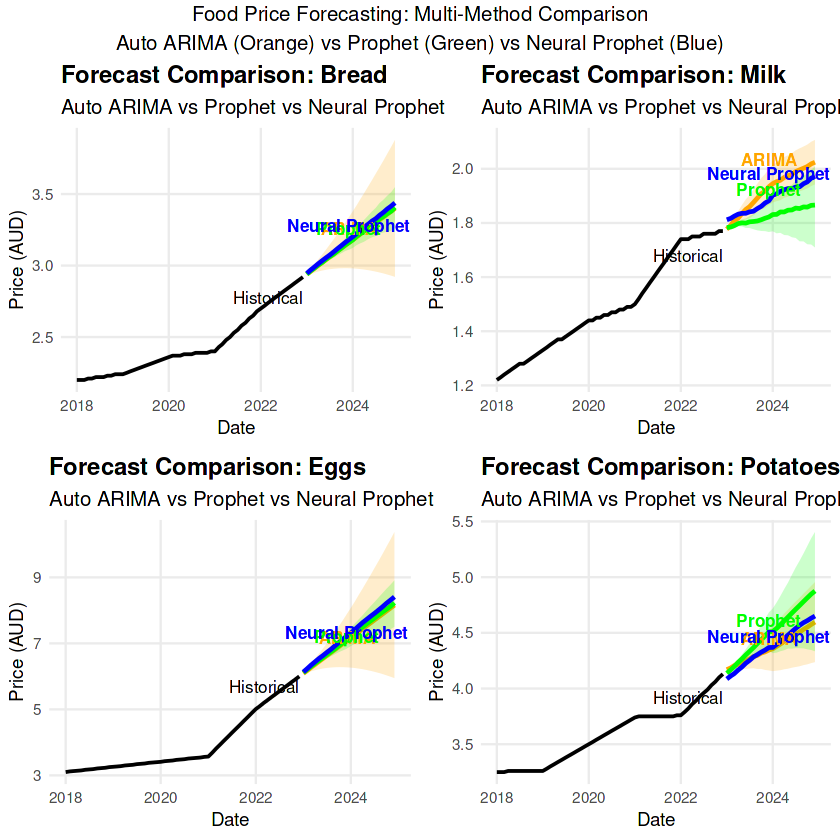

In [ ]:
# --- 5. COMBINED MULTI-PANEL PLOT (LIKE CEMENT PRODUCTION EXAMPLE) ---
# Create a 2x2 grid showing all food items
if(length(all_results) == 4) {
  combined_plot <- grid.arrange(
    all_results$Bread$plot + theme(legend.position = "none"),
    all_results$Milk$plot + theme(legend.position = "none"),
    all_results$Eggs$plot + theme(legend.position = "none"),
    all_results$Potatoes$plot + theme(legend.position = "none"),
    ncol = 2,
    top = "Food Price Forecasting: Multi-Method Comparison\nAuto ARIMA (Orange) vs Prophet (Green) vs Neural Prophet (Blue)"
  )
  
  print(combined_plot)
}

cat("\n=== ANALYSIS COMPLETE ===\n")
cat("Color Legend:\n")
cat("- Black: Historical Data\n")
cat("- Orange: Auto ARIMA Forecasts (with confidence intervals)\n")
cat("- Green: Prophet Forecasts (with confidence intervals)\n")
cat("- Blue: Neural Prophet Forecasts\n")
cat("- Shaded areas: 95% Confidence Intervals\n")